In [48]:
from datasets import DatasetDict, Dataset
from datasets import load_dataset
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
import ssl
from gensim.models import KeyedVectors
from huggingface_hub import hf_hub_download
from sentencepiece import SentencePieceProcessor
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer
import tensorflow as tf
import os

# Part 0: Dataset Preparation

In [49]:
dataset: DatasetDict = load_dataset("cornell-movie-review-data/rotten_tomatoes")
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [50]:
# Tokenize Words

# Disable SSL certificate verification
ssl._create_default_https_context = ssl._create_unverified_context

# Set the NLTK data path to the current directory's nltk_data folder
nltk_data_path = os.path.join(os.getcwd(), "nltk_data")
nltk.data.path.append(nltk_data_path)

# Download necessary tokenizer data to the specified folder
nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('wordnet', download_dir=nltk_data_path)
nltk.download('punkt_tab', download_dir=nltk_data_path)

print(f"NLTK data saved to: {nltk_data_path}")

NLTK data saved to: /Users/clem/Documents/GitHub/SC4002-Group-Assignment/nltk_data


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/clem/Documents/GitHub/SC4002-Group-
[nltk_data]     Assignment/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/clem/Documents/GitHub/SC4002-Group-
[nltk_data]     Assignment/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/clem/Documents/GitHub/SC4002-Group-
[nltk_data]     Assignment/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [51]:
def tokenize(row):
    text: str = row['text']
    # Tokenize text into words using NLTK
    row["tokens"] =  word_tokenize(text.lower())
    
    return row

train = train.map(tokenize)
val = val.map(tokenize)
test = test.map(tokenize)

In [52]:
# Build Vocabulary
def build_vocab(data: Dataset, column: str):
    vocab = Counter()
    for row in data:
        vocab.update(row[column])
    return vocab

vanilla_vocab = build_vocab(train, "tokens")

In [53]:
vanilla_vocab

Counter({'.': 11197,
         'the': 8034,
         ',': 8001,
         'a': 5879,
         'and': 4918,
         'of': 4815,
         'to': 3416,
         "'s": 2872,
         'is': 2848,
         'it': 2733,
         'that': 2129,
         'in': 2112,
         'as': 1409,
         'but': 1326,
         'with': 1274,
         'film': 1248,
         'this': 1187,
         'for': 1161,
         'movie': 1078,
         'an': 1067,
         'its': 1060,
         'you': 940,
         'be': 771,
         "n't": 741,
         'on': 719,
         'not': 661,
         'by': 653,
         'are': 592,
         'about': 581,
         'more': 575,
         'one': 574,
         'like': 572,
         'has': 561,
         'at': 557,
         'from': 542,
         '--': 536,
         'than': 529,
         'his': 519,
         'have': 515,
         '``': 507,
         'all': 504,
         'i': 466,
         'so': 446,
         "'": 438,
         'or': 422,
         'if': 419,
         'story': 384,
   

### Question 1a: 
What is the size of the vocabulary formed from your training data?


In [54]:
# Vocabulary Size
vocab_size = len(vanilla_vocab)
print("Vocabulary Size:", vocab_size)

Vocabulary Size: 18029


In [55]:
# Loading Pre-trained Word2Vec Embeddings
embed_model = KeyedVectors.load_word2vec_format(hf_hub_download(repo_id="Word2vec/nlpl_50", filename="model.bin"), binary=True, unicode_errors="ignore")

In [56]:
word2vec_vocab_lst = embed_model.key_to_index.keys()

### Question 1b:
We use OOV (out-of-vocabulary) to refer to those words appeared in the training data but not in the Word2vec (or Glove) dictionary. How many OOV words exist in your training data?

In [57]:
# Find OoV Words
oov_words = [word for word in vanilla_vocab if word not in word2vec_vocab_lst]
print("Number of OoV words:", len(oov_words))

Number of OoV words: 3808


In [58]:
print(oov_words)

['jean-claud', 'gorgeously', 'co-writer/director', 'too-tepid', 'keenly', 'wisegirls', 'fantasy-adventure', "'who", 'enrapturing', 'insistently', 'bleakly', 'frighteningly', 'moviegoing', 'good-hearted', 'pint-sized', 'grimness', 'whimsy', 'cantet', 'two-lane', 'fulford-wierzbicki', 'bona-fide', 'cartoonlike', "'compleja", 'intelectualmente', 'retadora', 'ladrón', 'orquídeas', 'esos', 'precisamente', 'originalidad', 'lacerating', "'50", 'cheesiness', 'unassuming', 'nettelbeck', 'parka-wrapped', 'singer/composer', '\x97', 'eccentrics', "'re", 'hit-or-miss', 'callar', 'domineering', 'masterfully', 'deftly', 'shadings', "'performance", 'ingeniously', 'page-turner', 'comedy/thriller', 'preposterous', 'misogynistic', 'orchestrate', 'overpraised', 'spycraft', 'lynchings', 'meeropol', 'anthropologically', "early-'80s", 'bromides', 'vertiginous', 'writer-director', 'imaginatively', 'lovers-on-the-run', 'piesiewicz', 'again-courage', 'oddballs', 'earnhart', 'quizzical', 'engrossing', 'suspenser

In [59]:
def process_tokens(tokens, oov_list, word2vec_model):
    processed_tokens = []

    for token in tokens:
        if token in oov_list:
            # Case 1: Token contains "'" and is in OOV list
            if "'" in token:
                # Remove apostrophe from the token
                processed_tokens.append(token.replace("'", ''))
            # Case 2: Token contains '-' and is in OOV list
            elif '-' in token:
                # Split the token on '-'
                split_tokens = token.split('-')

                # Check if all split parts exist in Word2Vec
                if all(sub_token in word2vec_model for sub_token in split_tokens):
                    # If all parts are in the Word2Vec vocabulary, split it
                    processed_tokens.extend(split_tokens)
                else:
                    # Else, merge it by removing '-'
                    processed_tokens.append(token.replace('-', ''))
            else:
                # If it's an OOV token but doesn't match other cases, keep it as-is
                processed_tokens.append(token)
        else:
            # If the token is not in OOV, keep it as-is
            processed_tokens.append(token)

    return processed_tokens

train = train.map(lambda row: {"processed_tokens": process_tokens(row["tokens"], oov_words, embed_model)})
val = val.map(lambda row: {"processed_tokens": process_tokens(row["tokens"], oov_words, embed_model)})
test = test.map(lambda row: {"processed_tokens": process_tokens(row["tokens"], oov_words, embed_model)})

Map: 100%|██████████| 1066/1066 [00:02<00:00, 382.34 examples/s]


In [60]:
# Build Vocab
processed_vocab = build_vocab(train, "processed_tokens")

# Find OoV Words
processed_oov_words = [word for word in processed_vocab if word not in word2vec_vocab_lst]
print("Number of OoV words:", len(processed_oov_words))

Number of OoV words: 2362


In [61]:
# Lemmatize the OOV words
def lemmatize_oov_words(tokens, oovs):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for token in tokens:
        if token in oovs:
            # Apply lemmatization to OOV word
            lemmatized_tokens.append(lemmatizer.lemmatize(token))
        else:
            # Keep in-vocab words unchanged
            lemmatized_tokens.append(token)
    return lemmatized_tokens

train = train.map(lambda row: {"lemmatized_tokens": lemmatize_oov_words(row["processed_tokens"], oov_words)})
val = val.map(lambda row: {"lemmatized_tokens": lemmatize_oov_words(row["processed_tokens"], oov_words)})
test = test.map(lambda row: {"lemmatized_tokens": lemmatize_oov_words(row["processed_tokens"], oov_words)})

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map: 100%|██████████| 1066/1066 [00:02<00:00, 363.68 examples/s]


In [62]:
# Build Vocab
lemmatized_vocab = build_vocab(train, "lemmatized_tokens")

# Find OoV Words
lemmatized_oov_words = [word for word in lemmatized_vocab if word not in word2vec_vocab_lst]
print("Number of OoV words:", len(lemmatized_oov_words))

Number of OoV words: 2171


In [63]:
print(lemmatized_oov_words)

['gorgeously', 'cowriter/director', 'keenly', 'wisegirls', 'enrapturing', 'insistently', 'bleakly', 'frighteningly', 'moviegoing', 'grimness', 'whimsy', 'cantet', 'cartoonlike', 'compleja', 'intelectualmente', 'retadora', 'ladrón', 'orquídeas', 'esos', 'precisamente', 'originalidad', 'lacerating', 'cheesiness', 'unassuming', 'nettelbeck', 'singer/composer', '\x97', 'callar', 'domineering', 'masterfully', 'deftly', 'ingeniously', 'comedy/thriller', 'preposterous', 'misogynistic', 'orchestrate', 'overpraised', 'spycraft', 'meeropol', 'anthropologically', 'early-80s', 'vertiginous', 'imaginatively', 'piesiewicz', 'earnhart', 'quizzical', 'engrossing', 'suspenser', 'obviation', 'recasts', 'kurys', 'fluidly', 'agreeably', 'enthralling', 'frustrates', 'thunderous', 'dulled', 'gorefests', 'cobbled', 'waydowntown', 'claptrap', 'gleefully', 'underwritten', 'rambunctious', '\x96', 'foible', 'makmalbaf', 'resolutely', 'tartness', 'engagingly', 'moviemaking', 'flaunting', 'actor/director', 'nuttge

In [64]:
# Stem the OOV words
def stem_oov_words(tokens, oovs):
    stemmer = PorterStemmer()
    stemmed_tokens = []
    for token in tokens:
        if token in oovs:
            # Apply stemming to OOV word
            stemmed_tokens.append(stemmer.stem(token))
        else:
            # Keep in-vocab words unchanged
            stemmed_tokens.append(token)
    return stemmed_tokens

train = train.map(lambda row: {"stemmed_tokens": stem_oov_words(row["lemmatized_tokens"], oov_words)})
val = val.map(lambda row: {"stemmed_tokens": stem_oov_words(row["lemmatized_tokens"], oov_words)})
test = test.map(lambda row: {"stemmed_tokens": stem_oov_words(row["lemmatized_tokens"], oov_words)})

Map: 100%|██████████| 1066/1066 [00:02<00:00, 429.20 examples/s]


In [65]:
# Build Vocab
stemmed_vocab = build_vocab(train, "stemmed_tokens")

# Find OoV Words
stemmed_oov_words = [word for word in stemmed_vocab if word not in word2vec_vocab_lst]
print("Number of OoV words:", len(stemmed_oov_words))

Number of OoV words: 1612


In [66]:
stemmed_oov_words

['cowriter/director',
 'keenli',
 'wisegirl',
 'enraptur',
 'bleakli',
 'frighteningli',
 'moviego',
 'whimsi',
 'cantet',
 'cartoonlik',
 'compleja',
 'intelectualment',
 'retadora',
 'ladrón',
 'precisament',
 'originalidad',
 'cheesi',
 'unassum',
 'nettelbeck',
 'singer/compos',
 '\x97',
 'callar',
 'deftli',
 'ingeni',
 'comedy/thril',
 'preposter',
 'orchestr',
 'overprais',
 'spycraft',
 'meeropol',
 'early-80s',
 'vertigin',
 'piesiewicz',
 'earnhart',
 'quizzic',
 'engross',
 'obviat',
 'fluidli',
 'agreeabl',
 'enthral',
 'frustrat',
 'gorefest',
 'cobbl',
 'waydowntown',
 'claptrap',
 'gleefulli',
 'underwritten',
 'rambuncti',
 '\x96',
 'foible',
 'makmalbaf',
 'resolut',
 'engagingli',
 'moviemak',
 'actor/director',
 'nuttgen',
 'blandli',
 'unabashedli',
 'schmaltzi',
 'unabash',
 'uncommerci',
 'persnicketi',
 'nonthreaten',
 'infuri',
 'fastidi',
 'ellefsen',
 'unflinch',
 'provocatu',
 'testud',
 'unsentiment',
 'shadowi',
 'hubac',
 'ribald',
 'shapelessli',
 'shainb

In [67]:
spp = SentencePieceProcessor()

In [68]:
spp.load(hf_hub_download(repo_id="BAAI/bge-m3", filename="sentencepiece.bpe.model"))

True

In [69]:
def tokenize_with_spp(row, token_col: str, oov):
    tokens: str = row[token_col]
    row["SP_Tokens"] = []
    # Tokenize text into words using SentencePiece
    for token in tokens:
        if token in oov:
            row["SP_Tokens"] += spp.encode_as_pieces(token)
        else:
            row["SP_Tokens"].append(token)
    
    return row

train = train.map(lambda row: tokenize_with_spp(row, "lemmatized_tokens", lemmatized_oov_words))
val = val.map(lambda row: tokenize_with_spp(row, "lemmatized_tokens", lemmatized_oov_words))
test = test.map(lambda row: tokenize_with_spp(row, "lemmatized_tokens", lemmatized_oov_words))

sentence_piece_vocab = dict(build_vocab(train, "SP_Tokens"))

def clean_vocab(v):
    cleaned_vocab = {}
    for token, token_id in v.items():
        # If the token length is greater than 1, remove '▁'
        if len(token) > 1:
            cleaned_token = token.replace('▁', '')
        else:
            cleaned_token = token
        # Add the cleaned token and its ID to the new vocab
        cleaned_vocab[cleaned_token] = token_id
    
    # Sizes of cleaned_vocab and original vocab will not match as duplicates which were previously distinct due to the '_' are now the same
    return cleaned_vocab
sentence_piece_vocab = clean_vocab(sentence_piece_vocab)

# Find OoV Words
sp_oov_words = [word for word in sentence_piece_vocab if word not in word2vec_vocab_lst]
print("Number of OoV words:", len(oov_words))

# We will hence not be using Sentence Piece since it does not help in reducing the number of OOV words

Map: 100%|██████████| 1066/1066 [00:01<00:00, 606.12 examples/s]


Number of OoV words: 3808


In [70]:
sp_oov_words

['▁',
 'insiste',
 'ightening',
 'rón',
 'quí',
 'esos',
 'precisamente',
 'ssum',
 '\x97',
 'ously',
 'prepo',
 'orchestr',
 'ropol',
 'ological',
 'ewicz',
 'obvi',
 'thra',
 'bble',
 '\x96',
 'fastidio',
 'provocat',
 'testu',
 'mming',
 'ically',
 'ettes',
 'melding',
 'wollte',
 'inski',
 'izing',
 'unele',
 'cted',
 'rious',
 'amalga',
 'ifying',
 'ized',
 '\x91',
 'ential',
 'ofrece',
 'condensa',
 'aprovechar',
 'ptic',
 'divertida',
 'sorprend',
 'rá',
 'lement',
 'ástica',
 'profund',
 'policial',
 'tsch',
 'irre',
 'cken',
 'schwe',
 'ated',
 'dled',
 'ttle',
 'ignan',
 'precipit',
 'inhos',
 'næ',
 'existência',
 'ável',
 'cón',
 'fascina',
 'zzy',
 'gging',
 'sque',
 'apesar',
 'consegue',
 'horri',
 'gged',
 'revela',
 'culmina',
 'certamente',
 'provoca',
 'madde',
 'pping',
 'kosmi',
 'gner',
 'yje',
 'ained',
 'ütt',
 'dramat',
 'pervers',
 'espectáculo',
 'contempla',
 'hacerlo',
 'complementar',
 'igualmente',
 'fascinant',
 'satisf',
 'captiv',
 'cked',
 'lles',
 'a

In [71]:
# Map the tokens to their corresponding IDs
def map_tokens_to_ids(row, embed_vocab_map, tokens_col):
    # First mark the unknown tokens as 0
    row["token_ids"] = [embed_vocab_map[token] if token in embed_vocab_map else 0 for token in row[tokens_col]]
    
    return row

# Pad the sequences to a fixed length
def pad_sequence(row, max_len, padding):
    row["token_ids"] = tf.keras.utils.pad_sequences([row["token_ids"]], maxlen=max_len, padding=padding,
                                                    value=0)[0]
    return row

def process_data(data, embed_vocab_map, token_col):
    # Map Tokens to IDs
    data = data.map(lambda row: map_tokens_to_ids(row, embed_vocab_map, token_col))
    
    # Pad Sequences
    max_len = max(len(row['token_ids']) for row in data)
    data = data.map(lambda row: pad_sequence(row, max_len, 'pre'))
    
    # Prune Dataset Columns to only include the necessary columns
    pruned_data = data.remove_columns(list(set(data.column_names) - {'token_ids', 'label'}))
    return pruned_data

train_dataset = process_data(train, embed_model.key_to_index, "stemmed_tokens")
val_dataset = process_data(val, embed_model.key_to_index, "stemmed_tokens")
test_dataset = process_data(test, embed_model.key_to_index, "stemmed_tokens")


Map: 100%|██████████| 1066/1066 [00:00<00:00, 5897.61 examples/s]


In [72]:
print(train_dataset[0]['token_ids'], train[0]['label'])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 212, 4199, 1470, 370475, 485, 2943, 212, 12413, 8590, 9281, 731, 45480, 21626, 45480, 388, 3561, 2842, 9281, 18612, 485, 4323, 179, 22087, 10905, 29458, 11889, 21134, 79039, 2, 13753, 395158, 2972, 140869, 2174, 14577, 70856, 1] 1


In [73]:
def create_tf_dataset(data):
    return tf.data.Dataset.from_tensor_slices((data['token_ids'], data['label']))

train_dataset = create_tf_dataset(train_dataset)
val_dataset = create_tf_dataset(val_dataset)
test_dataset = create_tf_dataset(test_dataset)

from constants import BATCH_SIZE

# Batch, shuffle and Prefetch the datasets
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [74]:
list(word2vec_vocab_lst)[0]

'</s>'

In [75]:
('</s>' in stemmed_vocab) and ('</s>' in vanilla_vocab)

False

Since the token '\</s>\' is not present in the training vocab but is present in the embeddings vocab, we will use it as the padding token.

In [76]:
for row in train_dataset.take(3):
    print(row)

(<tf.Tensor: shape=(32, 62), dtype=int32, numpy=
array([[    0,     0,     0, ...,   731,  2523,     1],
       [    0,     0,     0, ..., 13105,   212,  8012],
       [    0,     0,     0, ..., 20100,  4105,     1],
       ...,
       [    0,     0,     0, ...,   485, 66349,     1],
       [    0,     0,     0, ..., 22772, 62942,     1],
       [    0,     0,     0, ..., 13863,  2453,     1]], dtype=int32)>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>)
(<tf.Tensor: shape=(32, 62), dtype=int32, numpy=
array([[     0,      0,      0, ...,    388, 351761,      1],
       [     0,      0,      0, ...,  11500,  57418,      1],
       [     0,      0,      0, ...,   4618,  12160,      1],
       ...,
       [     0,      0,      0, ...,   5821,    101,      1],
       [     0,      0,      0, ...,    328,  46725,      1],
       [     0,      0,      0, ...,  67704, 

2024-11-10 21:30:01.794950: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Question 1c:
The existence of the OOV words is one of the well-known limitations of Word2vec (or Glove).
Without using any transformer-based language models (e.g., BERT, GPT, T5), what do you
think is the best strategy to mitigate such limitation? Implement your solution in your source
code. Show the corresponding code snippet.

Ans: One way would be to replace all '<UNK>' tokens that represent OOV words with 0. However, as the padding token is also set to 0, this is not ideal as this may confuse the model. Another better way would be to replace the OOV words with the average of the sequence.

In [77]:
# Map the tokens to their corresponding IDs
def map_tokens_to_ids_mitigate_oov(row, embed_vocab_map, tokens_col):
    # First mark the unknown tokens as 0
    row["token_ids"] = [embed_vocab_map[token] if token in embed_vocab_map else 0 for token in row[tokens_col]]
    
    # Find the average of sequence
    average = sum(row["token_ids"]) / len(row["token_ids"])
    
    # Replace the unknown tokens with the average
    row["token_ids"] = [average if token_id == 0 else token_id for token_id in row["token_ids"]]
    
    return row

def process_data_mitigate_oov(data, embed_vocab_map, token_col):
    # Map Tokens to IDs
    data = data.map(lambda row: map_tokens_to_ids_mitigate_oov(row, embed_vocab_map, token_col))
    
    # Pad Sequences
    max_len = max(len(row['token_ids']) for row in data)
    data = data.map(lambda row: pad_sequence(row, max_len, 'pre'))
    
    # Prune Dataset Columns to only include the necessary columns
    pruned_data = data.remove_columns(list(set(data.column_names) - {'token_ids', 'label'}))
    return pruned_data

# Part 2. Model Training & Evaluation - RNN

In [78]:
import keras
class SentimentRNNLastState(keras.Model):
    def __init__(self, embedding_model, rnn_units, output_dim):
        super(SentimentRNNLastState, self).__init__()

        # Embedding layer to map input words to word embeddings
        weights = embedding_model.vectors  # vectors themselves, a 2D numpy array    
        #index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?
    
        self.embedding = keras.layers.Embedding(
            input_dim=weights.shape[0],
            output_dim=weights.shape[1],
            weights=weights,
            trainable=False,
            mask_zero=True
        )
        
        # Recurrent layer (RNN)
        self.rnn = keras.layers.SimpleRNN(rnn_units, 
                                          activation="tanh",       # Help with exploding gradients
                                          return_sequences=False)  # Return only the last state
        
        # Drop 50% of units:
        #self.dropout = keras.layers.Dropout(0.5)
        
        # Layer to introduce non-linearity
        self.nonlinear = keras.layers.Dense(rnn_units, 
                                            activation='relu', # Help with vanishing gradients
                                            #kernel_regularizer=keras.regularizers.l2(0.01) # Help to reduce overfitting
                                            )
        
        # Drop 50% of units:
        self.dropout2 = keras.layers.Dropout(0.5)
        
        # Dense layer to aggregate RNN output and predict sentiment (binary classification)
        self.dense = keras.layers.Dense(output_dim, activation='sigmoid')
    
    def call(self, inputs):
        # Pass inputs through embedding layer
        x = self.embedding(inputs)
        
        # Pass embeddings through RNN layer
        x = self.rnn(x)
        
        # Dropout
        #x = self.dropout(x)
        
        # Pass to non-linear layer
        x = self.nonlinear(x)
        
        # Dropout
        x = self.dropout2(x)
        
        # Pass the RNN output through a dense layer for prediction
        output = self.dense(x)
        
        return output

In [79]:
from constants import ADAM_LR, SGD_LR

rnn_modellastState = SentimentRNNLastState(embed_model, 128, 1)
optimizer = tf.keras.optimizers.Adam(learning_rate=ADAM_LR)
optimizer = tf.keras.optimizers.SGD(learning_rate=SGD_LR)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  patience=10, 
                                                  start_from_epoch=20,
                                                  restore_best_weights=True)
rnn_modellastState.compile(optimizer, loss=loss, metrics=['accuracy'])
rnn_modellastState.summary()

Model: "sentiment_rnn_last_state"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   289,910,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,910,700 (1.08 GB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 289,910,700 (1.08 GB)

In [146]:
tf.keras.backend.clear_session()
tf.keras.utils.disable_interactive_logging()

rnn_last_state_hist = rnn_modellastState.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1, callbacks=[early_stopping], batch_size=BATCH_SIZE)

265/267 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8074 - loss: 0.4354

In [81]:
import matplotlib.pyplot as plt

def plot_history(hist, model_name):
    # Extract history data from the History object
    history = hist.history  # Ensure we're accessing the dictionary

    # Plot validation and training accuracy
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history['accuracy'], label='Training Accuracy')

    # Add title and axis labels
    plt.title(f'{model_name} Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Add legend
    plt.legend()

    # Display the plot
    plt.show()

# Call the function with the history object
plot_history(rnn_last_state_hist, 'RNN with Last State')


In [148]:
test_loss, test_acc = rnn_modellastState.evaluate(test_dataset)
print('\nTest Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

26/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4297 - loss: 0.8913
Test Loss: 0.6926727294921875
Test Accuracy: 0.600375235080719


In [82]:
class SentimentRNNMaxPool(keras.Model):
    def __init__(self, embedding_model, rnn_units, output_dim):
        super(SentimentRNNMaxPool, self).__init__()

        # Embedding layer to map input words to word embeddings
        weights = embedding_model.vectors  # vectors themselves, a 2D numpy array    
        #index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?
    
        self.embedding = keras.layers.Embedding(
            input_dim=weights.shape[0],
            output_dim=weights.shape[1],
            weights=weights,
            trainable=False,
            mask_zero=True
        )
        
        # Recurrent layer (RNN)
        self.rnn = keras.layers.SimpleRNN(rnn_units, 
                                          activation="tanh",    # Help with exploding gradients
                                          return_sequences=True)  # Return all hidden states
        
        # Drop 50% of units:
        #self.dropout = keras.layers.Dropout(0.5)
        
        # Max Pool the hidden states
        self.max_pool = keras.layers.GlobalMaxPool1D()
        
        # Layer to introduce non-linearity
        self.nonlinear = keras.layers.Dense(1, 
                                            activation='relu', # Help with vanishing gradients
                                            #kernel_regularizer=keras.regularizers.l2(0.01)
                                            )
        
        # Drop 50% of units:
        self.dropout2 = keras.layers.Dropout(0.5)
        
        # Dense layer to aggregate RNN output and predict sentiment (binary classification)
        self.dense = keras.layers.Dense(output_dim, activation='sigmoid')
    
    def call(self, inputs):
        # Pass inputs through embedding layer
        x = self.embedding(inputs)
        
        # Pass embeddings through RNN layer
        x = self.rnn(x)
        
        # Max Pool
        x = self.max_pool(x)
        
        # Dropout
        #x = self.dropout(x)
        
        # Pass to non-linear layer
        x = self.nonlinear(x)
        
        # Dropout
        x = self.dropout2(x)
        
        # Pass the RNN output through a dense layer for prediction
        output = self.dense(x)
        
        return output

In [83]:
rnn_modelMaxPool = SentimentRNNMaxPool(embed_model, 128, 1)
# optimizer = tf.keras.optimizers.Adam(learning_rate=ADAM_LR)
optimizer = tf.keras.optimizers.SGD(learning_rate=SGD_LR)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  patience=10, 
                                                  start_from_epoch=20,
                                                  restore_best_weights=True)
rnn_modelMaxPool.compile(optimizer, loss=loss, metrics=['accuracy'])
rnn_modelMaxPool.summary()

Model: "sentiment_rnn_max_pool"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   289,910,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,910,700 (1.08 GB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 289,910,700 (1.08 GB)

In [151]:
tf.keras.backend.clear_session()
tf.keras.utils.disable_interactive_logging()

maxpool_history = rnn_modelMaxPool.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1, callbacks=[early_stopping])

266/267 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4845 - loss: 0.6937

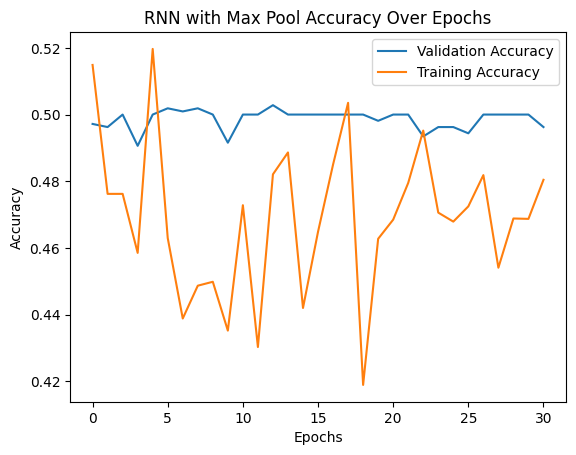

In [152]:
plot_history(maxpool_history, "RNN with Max Pool")

In [153]:
test_loss, test_acc = rnn_modelMaxPool.evaluate(test_dataset)
print('\nTest Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0923 - loss: 0.6986  
Test Loss: 0.6931280493736267
Test Accuracy: 0.5


In [84]:
class SentimentRNNAvgPool(keras.Model):
    def __init__(self, embedding_model, rnn_units, output_dim):
        super(SentimentRNNAvgPool, self).__init__()

        # Embedding layer to map input words to word embeddings
        weights = embedding_model.vectors  # vectors themselves, a 2D numpy array    
        #index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?
    
        self.embedding = keras.layers.Embedding(
            input_dim=weights.shape[0],
            output_dim=weights.shape[1],
            weights=weights,
            trainable=False,
            mask_zero=True
        )
        
        # Recurrent layer (RNN)
        self.rnn = keras.layers.SimpleRNN(rnn_units,
                                          activation="tanh",    # Help with exploding gradients
                                          return_sequences=True)  # Return all hidden states
        
        # Drop 50% of units:
        #self.dropout = keras.layers.Dropout(0.5)
        
        # Avg Pool the hidden states
        self.avg_pool = keras.layers.GlobalAvgPool1D()
        
        # Layer to introduce non-linearity
        self.nonlinear = keras.layers.Dense(rnn_units, 
                                            activation='relu',  # Help with vanishing gradients 
                                            #kernel_regularizer=keras.regularizers.l2(0.01)
                                            )
        
        # Drop 50% of units:
        self.dropout2 = keras.layers.Dropout(0.5)
        
        # Dense layer to aggregate RNN output and predict sentiment (binary classification)
        self.dense = keras.layers.Dense(output_dim, activation='sigmoid')
    
    def call(self, inputs):
        # Pass inputs through embedding layer
        x = self.embedding(inputs)
        
        # Pass embeddings through RNN layer
        x = self.rnn(x)
        
        # Avg Pool
        x = self.avg_pool(x)
        
        # Dropout
        #x = self.dropout(x)
        
        # Pass to non-linear layer
        x = self.nonlinear(x)
        
        # Dropout
        x = self.dropout2(x)
        
        # Pass the RNN output through a dense layer for prediction
        output = self.dense(x)
        
        return output

In [85]:
rnn_with_avg_pool_model = SentimentRNNAvgPool(embed_model, 128, 1)
# optimizer = tf.keras.optimizers.Adam(learning_rate=ADAM_LR)
optimizer = tf.keras.optimizers.SGD(learning_rate=SGD_LR)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  patience=10, 
                                                  start_from_epoch=20,
                                                  restore_best_weights=True)
rnn_with_avg_pool_model.compile(optimizer, loss=loss, metrics=['accuracy'])
rnn_with_avg_pool_model.summary()

Model: "sentiment_rnn_avg_pool"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   289,910,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,910,700 (1.08 GB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 289,910,700 (1.08 GB)

In [156]:
tf.keras.backend.clear_session()
tf.keras.utils.disable_interactive_logging()

avgpool_history = rnn_with_avg_pool_model.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1, callbacks=[early_stopping], validation_batch_size=BATCH_SIZE)

265/267 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6560 - loss: 0.6266

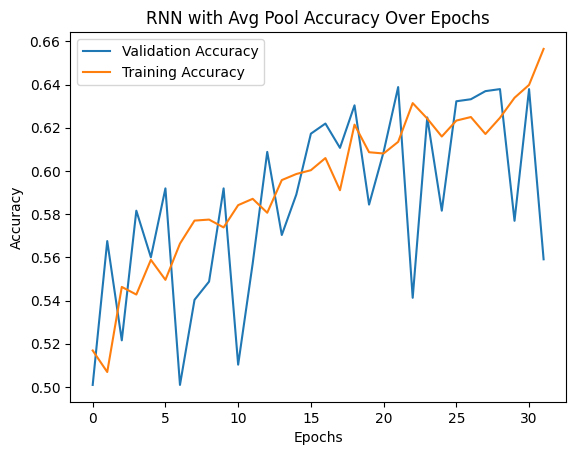

In [157]:
plot_history(avgpool_history, "RNN with Avg Pool")

In [158]:
test_loss, test_acc = rnn_with_avg_pool_model.evaluate(test_dataset)
print('\nTest Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6042 - loss: 0.6332 
Test Loss: 0.6377020478248596
Test Accuracy: 0.6313320994377136


In [86]:
class AttentionLayer(keras.layers.Layer):
    def __init__(self, rnn_units):
        super(AttentionLayer, self).__init__()
        # Define a trainable weight that represents attention scores
        self.W = keras.layers.Dense(rnn_units, activation='tanh')  # Attention score weights
        self.v = keras.layers.Dense(1, activation=None)  # Attention output

    def call(self, hidden_states, mask=None):
        # hidden_states.shape == (batch_size, timesteps, rnn_units)
        attention_scores = self.v(self.W(hidden_states))  # shape == (batch_size, timesteps, 1)

        if mask is not None:
            # Expand mask shape to match attention_scores shape (batch_size, timesteps, 1)
            mask = tf.cast(mask, dtype=tf.float32)  # Convert mask to float32
            mask = tf.expand_dims(mask, axis=-1)  # shape becomes (batch_size, timesteps, 1)
            attention_scores += (1.0 - mask) * -1e9  # Apply mask: very negative values ignored by softmax

        attention_weights = tf.nn.softmax(attention_scores, axis=1)  # shape == (batch_size, timesteps, 1)

        # Broadcast attention_weights to match hidden_states dimensions
        weighted_sum = tf.reduce_sum(attention_weights * hidden_states, axis=1)  # shape == (batch_size, rnn_units)

        return weighted_sum, attention_weights



class SentimentRNNAttentionPool(keras.Model):
    def __init__(self, embedding_model, rnn_units, output_dim):
        super(SentimentRNNAttentionPool, self).__init__()

        # Embedding layer to map input words to word embeddings
        weights = embedding_model.vectors  # vectors themselves, a 2D numpy array    
        self.embedding = keras.layers.Embedding(
            input_dim=weights.shape[0],
            output_dim=weights.shape[1],
            weights=[weights],
            trainable=False,
            mask_zero=True
        )
        
        # Recurrent layer (RNN)
        self.rnn = keras.layers.SimpleRNN(rnn_units,
                                          activation="tanh",
                                          return_sequences=True)  # Return all hidden states
        
        # Attention mechanism
        self.attention = AttentionLayer(rnn_units)
        
        # Dropout layer
        #self.dropout = keras.layers.Dropout(0.5)
        
        # Dense layer for non-linearity
        self.nonlinear = keras.layers.Dense(rnn_units, 
                                            activation='relu', 
                                            #kernel_regularizer=keras.regularizers.l2(0.01)
                                            )
        
        # Another dropout layer
        self.dropout2 = keras.layers.Dropout(0.5)
        
        # Dense layer for binary classification
        self.dense = keras.layers.Dense(output_dim, activation='sigmoid')
    
    def call(self, inputs):
        # Pass inputs through embedding layer
        x = self.embedding(inputs)
        
        # Pass embeddings through RNN layer
        x = self.rnn(x)
        
        # Apply attention mechanism
        x, _ = self.attention(x)
        
        # Dropout after attention
        #x = self.dropout(x)
        
        # Apply non-linear layer
        x = self.nonlinear(x)
        
        # Dropout after non-linear layer
        x = self.dropout2(x)
        
        # Final dense layer for sentiment prediction
        output = self.dense(x)
        
        return output

In [87]:
rnn_with_attn_pool = SentimentRNNAttentionPool(embed_model, 128, 1)
#optimizer = tf.keras.optimizers.Adam(learning_rate=ADAM_LR)
optimizer = tf.keras.optimizers.SGD(learning_rate=SGD_LR)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=10,
                                                  start_from_epoch=20,
                                                  restore_best_weights=True)
rnn_with_attn_pool.compile(optimizer, loss=loss, metrics=['accuracy'])
print(rnn_with_attn_pool.summary())

Model: "sentiment_rnn_attention_pool"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   289,910,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ ?                      │   0 (unbuilt) │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,910,700 (1.08 GB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 289,910,700 (1.08 GB)

None


In [161]:
tf.keras.backend.clear_session()
tf.keras.utils.disable_interactive_logging()

history_rnn_with_attn_pool = rnn_with_attn_pool.fit(train_dataset,
                                                    validation_data=val_dataset, epochs=100, verbose=1, callbacks=[early_stopping],
                                                     validation_batch_size=BATCH_SIZE)

267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7966 - loss: 0.4454

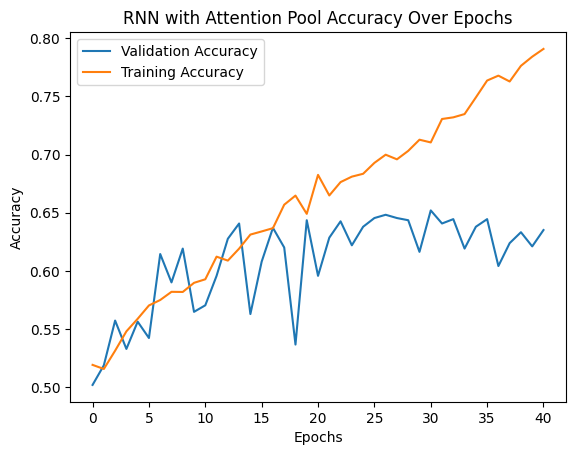

In [162]:
plot_history(history_rnn_with_attn_pool, "RNN with Attention Pool")

In [163]:
test_loss, test_acc = rnn_with_attn_pool.evaluate(test_dataset)
print('\nTest Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

29/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6055 - loss: 0.6255
Test Loss: 0.616664469242096
Test Accuracy: 0.6491557359695435


### Question 2a:
Report the final configuration of your best model, namely the number of training epochs,
learning rate, optimizer, batch size.

Ans: The best model we have trained is the RNN with Attention Pooling. The final configuration of the best model is as follows:
- Number of Training Epochs: 100
- Learning Rate: 0.01
- Optimizer: SGD
- Batch Size: 32
- Early Stopping: Patience of 10 epochs, starting from epoch 20, with restoring best weights enabled.
- Loss Function: Binary Crossentropy
- Metrics: Accuracy
- Activation Functions: tanh (RNN units), relu (non-linear layer), sigmoid (output layer)

### Question 2b:
Report the accuracy score on the test set, as well as the accuracy score on the validation
set for each epoch during training.

Test Accuracy: 0.65853
Validation Accuracy: As above (in the graph)

### Question 2c:
RNNs produce a hidden vector for each word, instead of the entire sentence. Which methods
have you tried in deriving the final sentence representation to perform sentiment classification?
Describe all the strategies you have implemented, together with their accuracy scores on the
test set.

Ans: We have tried the following methods to derive the final sentence representation:
1. Last State: We used the hidden state of the last RNN unit as the sentence representation. **Test Accuracy: 0.5**
2. Max Pooling: We applied max pooling to the hidden states of all RNN units to derive the sentence representation. **Test Accuracy: 0.62008**
3. Average Pooling: We applied average pooling to the hidden states of all RNN units to derive the sentence representation. **Test Accuracy: 0.65853**

# Part 3. Enhancement

### Part 3.1:
Instead of keeping the word embeddings fixed, now update the word embeddings (the same
way as model parameters) during the training process.

In [88]:
class SentimentRNNAttentionPool(keras.Model):
    def __init__(self, embedding_model, rnn_units, output_dim):
        super(SentimentRNNAttentionPool, self).__init__()

        # Embedding layer to map input words to word embeddings
        weights = embedding_model.vectors  # vectors themselves, a 2D numpy array    
        self.embedding = keras.layers.Embedding(
            input_dim=weights.shape[0],
            output_dim=weights.shape[1],
            weights=[weights],
            trainable=True,
            mask_zero=True
        )
        
        # Recurrent layer (RNN)
        self.rnn = keras.layers.SimpleRNN(rnn_units,
                                          activation="tanh",
                                          return_sequences=True)  # Return all hidden states
        
        # Attention mechanism
        self.attention = AttentionLayer(rnn_units)
        
        # Dropout layer
        #self.dropout = keras.layers.Dropout(0.5)
        
        # Dense layer for non-linearity
        self.nonlinear = keras.layers.Dense(rnn_units, 
                                            activation='relu', 
                                            #kernel_regularizer=keras.regularizers.l2(0.01)
                                            )
        
        # Another dropout layer
        self.dropout2 = keras.layers.Dropout(0.5)
        
        # Dense layer for binary classification
        self.dense = keras.layers.Dense(output_dim, activation='sigmoid')
    
    def call(self, inputs):
        # Pass inputs through embedding layer
        x = self.embedding(inputs)
        
        # Pass embeddings through RNN layer
        x = self.rnn(x)
        
        # Apply attention mechanism
        x, _ = self.attention(x)
        
        # Dropout after attention
        #x = self.dropout(x)
        
        # Apply non-linear layer
        x = self.nonlinear(x)
        
        # Dropout after non-linear layer
        x = self.dropout2(x)
        
        # Final dense layer for sentiment prediction
        output = self.dense(x)
        
        return output

In [89]:
rnn_with_attn_pool_trainable_embed = SentimentRNNAttentionPool(embed_model, 128, 1)
#optimizer = tf.keras.optimizers.Adam(learning_rate=ADAM_LR)
optimizer = tf.keras.optimizers.SGD(learning_rate=SGD_LR)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=10,
                                                  start_from_epoch=20,
                                                  restore_best_weights=True)
rnn_with_attn_pool_trainable_embed.compile(optimizer, loss=loss, metrics=['accuracy'])
print(rnn_with_attn_pool_trainable_embed.summary())

Model: "sentiment_rnn_attention_pool_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   289,910,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_1               │ ?                      │   0 (unbuilt) │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,910,700 (1.08 GB)

 Trainable params: 289,910,700 (1.08 GB)

 Non-trainable params: 0 (0.00 B)

None


In [166]:
tf.keras.backend.clear_session()
tf.keras.utils.disable_interactive_logging()

history_rnn_with_attn_pool_trainable_embed = rnn_with_attn_pool_trainable_embed.fit(train_dataset,
                                                    validation_data=val_dataset, epochs=100, verbose=1, callbacks=[early_stopping],
                                                     validation_batch_size=BATCH_SIZE)

267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7894 - loss: 0.4573

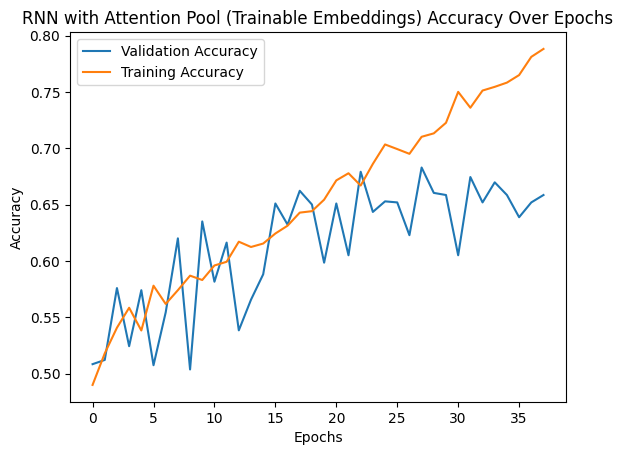

In [167]:
plot_history(history_rnn_with_attn_pool_trainable_embed, "RNN with Attention Pool (Trainable Embeddings)")

In [168]:
test_loss, test_acc = rnn_with_attn_pool_trainable_embed.evaluate(test_dataset)
print('\nTest Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6603 - loss: 0.5990
Test Loss: 0.5961136817932129
Test Accuracy: 0.6801125407218933


### Part 3.2:
As discussed in Question 1(c), apply your solution in mitigating the influence of OOV words
and train your model again.

In [90]:
train_dataset_mitigate_oov = process_data_mitigate_oov(train, embed_model.key_to_index, "stemmed_tokens")
val_dataset_mitigate_oov = process_data_mitigate_oov(val, embed_model.key_to_index, "stemmed_tokens")
test_dataset_mitigate_oov = process_data_mitigate_oov(test, embed_model.key_to_index, "stemmed_tokens")

train_dataset_mitigate_oov = create_tf_dataset(train_dataset_mitigate_oov)
val_dataset_mitigate_oov = create_tf_dataset(val_dataset_mitigate_oov)
test_dataset_mitigate_oov = create_tf_dataset(test_dataset_mitigate_oov)

# Batch, shuffle and Prefetch the datasets
train_dataset_mitigate_oov = train_dataset_mitigate_oov.batch(BATCH_SIZE).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_dataset_mitigate_oov = val_dataset_mitigate_oov.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset_mitigate_oov = test_dataset_mitigate_oov.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Map: 100%|██████████| 1066/1066 [00:00<00:00, 9117.66 examples/s]


In [91]:
rnn_with_attn_pool_trainable_embed_mit_oov = SentimentRNNAttentionPool(embed_model, 128, 1)
#optimizer = tf.keras.optimizers.Adam(learning_rate=ADAM_LR)
optimizer = tf.keras.optimizers.SGD(learning_rate=SGD_LR)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=10,
                                                  start_from_epoch=20,
                                                  restore_best_weights=True)
rnn_with_attn_pool_trainable_embed_mit_oov.compile(optimizer, loss=loss, metrics=['accuracy'])
print(rnn_with_attn_pool_trainable_embed_mit_oov.summary())

Model: "sentiment_rnn_attention_pool_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   289,910,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_2               │ ?                      │   0 (unbuilt) │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,910,700 (1.08 GB)

 Trainable params: 289,910,700 (1.08 GB)

 Non-trainable params: 0 (0.00 B)

None


In [171]:
tf.keras.backend.clear_session()
tf.keras.utils.disable_interactive_logging()

history_rnn_with_attn_pool_trainable_embed_mit_oov = rnn_with_attn_pool_trainable_embed_mit_oov.fit(train_dataset,
                                                    validation_data=val_dataset, epochs=100, verbose=1, callbacks=[early_stopping],
                                                     validation_batch_size=BATCH_SIZE)

267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7758 - loss: 0.4721

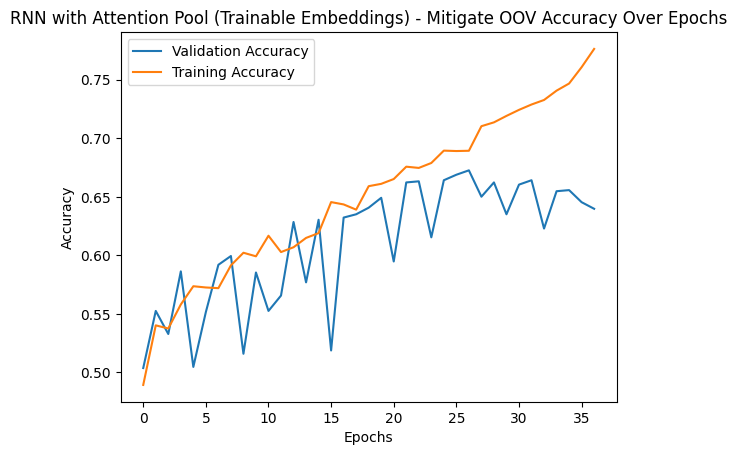

In [172]:
plot_history(history_rnn_with_attn_pool_trainable_embed_mit_oov, "RNN with Attention Pool (Trainable Embeddings) - Mitigate OOV")

In [173]:
test_loss, test_acc = rnn_with_attn_pool_trainable_embed_mit_oov.evaluate(test_dataset)
print('\nTest Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6169 - loss: 0.6215
Test Loss: 0.6129133105278015
Test Accuracy: 0.6557223200798035


### Part 3.3:
Keeping the above two adjustments, replace your simple RNN model in Part 2 with a biLSTM
model and a biGRU model, incorporating recurrent computations in both directions and
stacking multiple layers if possible.

In [92]:
class SentimentBiLSTM(keras.Model):
    def __init__(self, embedding_model, rnn_units, output_dim):
        super(SentimentBiLSTM, self).__init__()

        # Embedding layer to map input words to word embeddings
        weights = embedding_model.vectors  # vectors themselves, a 2D numpy array    
        self.embedding = keras.layers.Embedding(
            input_dim=weights.shape[0],
            output_dim=weights.shape[1],
            weights=[weights],
            trainable=True,
            mask_zero=True
        )
        
        # Recurrent layer (Bidirectional LSTM)
        self.rnn = keras.layers.Bidirectional(
            keras.layers.LSTM(rnn_units,
                              activation="tanh",
                              return_sequences=True)  # Return all hidden states
        )
        
        # Attention mechanism
        self.attention = AttentionLayer(rnn_units * 2)  # Multiply by 2 due to bidirectional LSTM
        
        # Dropout layer
        #self.dropout = keras.layers.Dropout(0.5)
        
        # Dense layer for non-linearity
        self.nonlinear = keras.layers.Dense(rnn_units * 2,  # Adjust input size due to bidirectional LSTM
                                            activation='relu', 
                                            kernel_regularizer=keras.regularizers.l2(0.01))
        
        # Another dropout layer
        self.dropout2 = keras.layers.Dropout(0.5)
        
        # Dense layer for binary classification
        self.dense = keras.layers.Dense(output_dim, activation='sigmoid')
    
    def call(self, inputs):
        # Pass inputs through embedding layer
        x = self.embedding(inputs)
        
        # Pass embeddings through Bidirectional LSTM layer
        x = self.rnn(x)
        
        # Apply attention mechanism
        x, _ = self.attention(x)
        
        # Dropout after LSTM
        #x = self.dropout(x)
        
        # Apply non-linear layer
        x = self.nonlinear(x)
        
        # Dropout after non-linear layer
        x = self.dropout2(x)
        
        # Final dense layer for sentiment prediction
        output = self.dense(x)
        
        return output

In [93]:
bilstm = SentimentBiLSTM(embed_model, 128, 1)
# optimizer = tf.keras.optimizers.Adam(learning_rate=ADAM_LR)
optimizer = tf.keras.optimizers.SGD(learning_rate=SGD_LR)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  patience=10, 
                                                  start_from_epoch=20,
                                                  restore_best_weights=True)
bilstm.compile(optimizer, loss=loss, metrics=['accuracy'])
bilstm.summary()

Model: "sentiment_bi_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   289,910,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_3               │ ?                      │   0 (unbuilt) │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,910,700 (1.08 GB)

 Trainable params: 289,910,700 (1.08 GB)

 Non-trainable params: 0 (0.00 B)

In [176]:
tf.keras.backend.clear_session()
tf.keras.utils.disable_interactive_logging()

bilstm_history = bilstm.fit(train_dataset_mitigate_oov, validation_data=val_dataset_mitigate_oov, epochs=100, verbose=1, callbacks=[early_stopping])

267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.6800 - loss: 0.6007

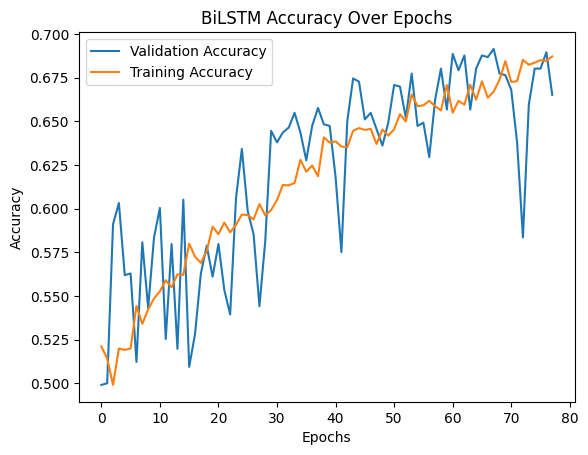

In [177]:
plot_history(bilstm_history, "BiLSTM")

In [178]:
test_loss, test_acc = bilstm.evaluate(test_dataset_mitigate_oov)
print('\nTest Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6887 - loss: 0.5829
Test Loss: 0.6072396039962769
Test Accuracy: 0.6735459566116333


In [94]:
class SentimentBiGRU(keras.Model):
    def __init__(self, embedding_model, rnn_units, output_dim):
        super(SentimentBiGRU, self).__init__()

        # Embedding layer to map input words to word embeddings
        weights = embedding_model.vectors  # vectors themselves, a 2D numpy array    
        self.embedding = keras.layers.Embedding(
            input_dim=weights.shape[0],
            output_dim=weights.shape[1],
            weights=[weights],
            trainable=True,
            mask_zero=True
        )
        
        # Recurrent layer (biGRU)
        self.rnn = keras.layers.Bidirectional(
            keras.layers.GRU(rnn_units,
                             activation="tanh",
                             return_sequences=True))  # Return all hidden states
        
        # Dropout layer
        #self.dropout = keras.layers.Dropout(0.5)
        
        # Attention mechanism
        self.attention = AttentionLayer(rnn_units * 2)  # rnn_units * 2 for bi-directional output
        
        # Dense layer for non-linearity
        self.nonlinear = keras.layers.Dense(rnn_units, 
                                            activation='relu', 
                                            kernel_regularizer=keras.regularizers.l2(0.01))
        
        # Another dropout layer
        self.dropout2 = keras.layers.Dropout(0.5)
        
        # Dense layer for binary classification
        self.dense = keras.layers.Dense(output_dim, activation='sigmoid')
    
    def call(self, inputs):
        # Pass inputs through embedding layer
        x = self.embedding(inputs)
        
        # Pass embeddings through biGRU layer
        x = self.rnn(x)
        
        # Dropout after biGRU
        #x = self.dropout(x)
        
        # Apply attention mechanism
        x, _ = self.attention(x)
        
        # Apply non-linear layer
        x = self.nonlinear(x)
        
        # Dropout after non-linear layer
        x = self.dropout2(x)
        
        # Final dense layer for sentiment prediction
        output = self.dense(x)
        
        return output

In [95]:
bigru = SentimentBiGRU(embed_model, 128, 1)
# optimizer = tf.keras.optimizers.Adam(learning_rate=ADAM_LR)
optimizer = tf.keras.optimizers.SGD(learning_rate=SGD_LR)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=10,
                                                  start_from_epoch=20,
                                                  restore_best_weights=True)
bigru.compile(optimizer, loss=loss, metrics=['accuracy'])
bigru.summary()

Model: "sentiment_bi_gru"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   289,910,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_4               │ ?                      │   0 (unbuilt) │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,910,700 (1.08 GB)

 Trainable params: 289,910,700 (1.08 GB)

 Non-trainable params: 0 (0.00 B)

In [181]:
tf.keras.backend.clear_session()
tf.keras.utils.disable_interactive_logging()

bigru_history = bigru.fit(train_dataset_mitigate_oov, validation_data=val_dataset_mitigate_oov, epochs=100, verbose=1,
                            callbacks=[early_stopping])

267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.6632 - loss: 0.6258

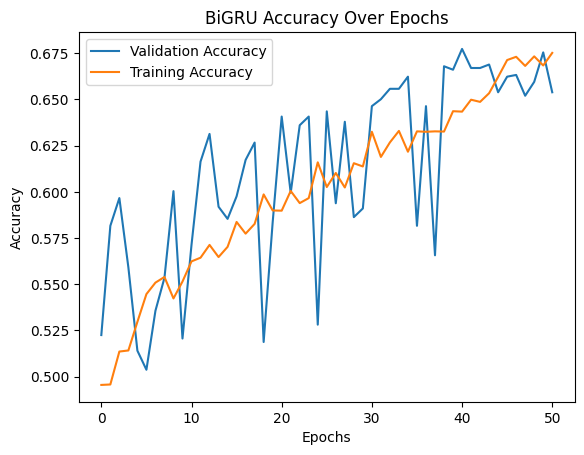

In [182]:
plot_history(bigru_history, "BiGRU")

In [183]:
test_loss, test_acc = bigru.evaluate(test_dataset_mitigate_oov)
print('\nTest Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

/Users/clem/Documents/GitHub/SC4002-Group-Assignment/venv/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'attention_layer' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.6552 - loss: 0.6375
Test Loss: 0.6471847295761108
Test Accuracy: 0.6641650795936584


### Part 3.4:
Keeping the above two adjustments, replace your simple RNN model in Part 2 with a Convolutional
Neural Network (CNN) to produce sentence representations and perform sentiment
classification.

In [96]:
class SentimentCNN(keras.Model):
    def __init__(self, embedding_model, cnn_filters, kernel_size, output_dim):
        super(SentimentCNN, self).__init__()

        # Embedding layer to map input words to word embeddings
        weights = embedding_model.vectors  # vectors themselves, a 2D numpy array    
        self.embedding = keras.layers.Embedding(
            input_dim=weights.shape[0],
            output_dim=weights.shape[1],
            weights=[weights],
            trainable=True,
            mask_zero=True
        )
        
        # Convolutional layer (CNN)
        self.conv1d = keras.layers.Conv1D(
            filters=cnn_filters,
            kernel_size=kernel_size,
            activation='relu',
            padding='same'
        )
        
        # Attention mechanism
        self.attention = AttentionLayer(cnn_filters)  # Adjust attention to CNN filter size
        
        # Dense layer for non-linearity
        self.nonlinear = keras.layers.Dense(cnn_filters, 
                                            activation='relu', 
                                            kernel_regularizer=keras.regularizers.l2(0.01))
        
        # Dropout layer
        self.dropout = keras.layers.Dropout(0.5)
        
        # Dense layer for binary classification
        self.dense = keras.layers.Dense(output_dim, activation='sigmoid')
    
    def call(self, inputs):
        # Pass inputs through embedding layer
        x = self.embedding(inputs)
        
        # Pass embeddings through Conv1D layer
        x = self.conv1d(x)
        
        #print('conv shape:', x.shape)
        
        # Apply attention mechanism
        x, _ = self.attention(x)
        
        #print('attention shape:', x.shape)
        
        # Apply non-linear layer
        x = self.nonlinear(x)
        
        #print('nonlinear shape:', x.shape)
        
        # Dropout after non-linear layer
        x = self.dropout(x)
        
        #print('dropout shape:', x.shape)
        
        # Final dense layer for sentiment prediction
        output = self.dense(x)
        
        #print('output shape:', output.shape)
        
        return output


In [97]:
cnn_model = SentimentCNN(embed_model, 128, 3, 1)
# optimizer = tf.keras.optimizers.Adam(learning_rate=ADAM_LR)
optimizer = tf.keras.optimizers.SGD(learning_rate=SGD_LR)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=10,
                                                  start_from_epoch=20,
                                                  restore_best_weights=True)
cnn_model.compile(optimizer, loss=loss, metrics=['accuracy'])

In [98]:
cnn_model.summary()

Model: "sentiment_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   289,910,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_5               │ ?                      │   0 (unbuilt) │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,910,700 (1.08 GB)

 Trainable params: 289,910,700 (1.08 GB)

 Non-trainable params: 0 (0.00 B)

In [101]:
tf.keras.backend.clear_session()
tf.keras.utils.disable_interactive_logging()

cnn_history = cnn_model.fit(train_dataset_mitigate_oov, validation_data=val_dataset_mitigate_oov, epochs=100, verbose=1,
                            callbacks=[early_stopping])

/Users/clem/Documents/GitHub/SC4002-Group-Assignment/venv/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.6924 - loss: 0.5951

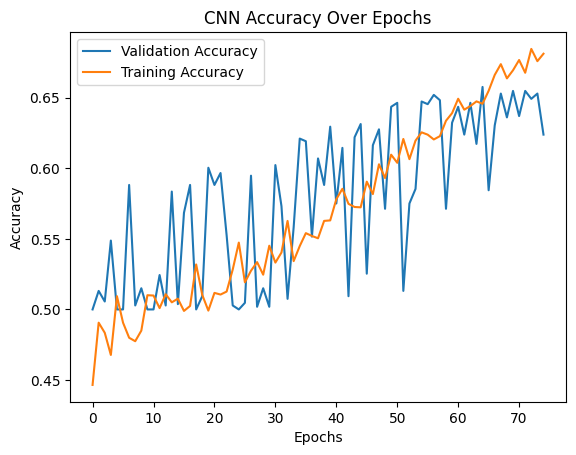

In [102]:
plot_history(cnn_history, "CNN")

In [103]:
test_loss, test_acc = cnn_model.evaluate(test_dataset_mitigate_oov)
print('\nTest Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

/Users/clem/Documents/GitHub/SC4002-Group-Assignment/venv/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7094 - loss: 0.5845
Test Loss: 0.632146954536438
Test Accuracy: 0.6472795605659485


In [107]:
# Save all models:
# rnn_modellastState.export('models/rnn_last_state')
# rnn_modelMaxPool.export('models/rnn_max_pool')
# rnn_with_avg_pool_model.export('models/rnn_avg_pool')
# rnn_with_attn_pool.export('models/rnn_attention_pool')
# rnn_with_attn_pool_trainable_embed.export('models/rnn_attention_pool_trainable_embed')
# rnn_with_attn_pool_trainable_embed_mit_oov.export('models/rnn_attention_pool_trainable_embed_mit_oov')
# bilstm.export('models/bilstm')
# bigru.export('models/bigru')
cnn_model.export('models/cnn')

/Users/clem/Documents/GitHub/SC4002-Group-Assignment/venv/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


INFO:tensorflow:Assets written to: models/cnn/assets


INFO:tensorflow:Assets written to: models/cnn/assets


In [110]:
# Save weights of CNN
cnn_model.save_weights('weights/cnn.weights.h5')

In [192]:
# Save all histories:
import pickle
with open('histories/rnn_last_state_history.pkl', 'wb') as f:
    pickle.dump(rnn_last_state_hist.history, f)
    
with open('histories/rnn_max_pool_history.pkl', 'wb') as f:
    pickle.dump(maxpool_history.history, f)
    
with open('histories/rnn_avg_pool_history.pkl', 'wb') as f:
    pickle.dump(avgpool_history.history, f)
    
with open('histories/rnn_attention_pool_history.pkl', 'wb') as f:
    pickle.dump(history_rnn_with_attn_pool.history, f)

with open('histories/rnn_attention_pool_trainable_embed_history.pkl', 'wb') as f:
    pickle.dump(history_rnn_with_attn_pool_trainable_embed.history, f)

with open('histories/rnn_attention_pool_trainable_embed_mit_oov_history.pkl', 'wb') as f:
    pickle.dump(history_rnn_with_attn_pool_trainable_embed_mit_oov.history, f)

with open('histories/bilstm_history.pkl', 'wb') as f:
    pickle.dump(bilstm_history.history, f)

with open('histories/bigru_history.pkl', 'wb') as f:
    pickle.dump(bigru_history.history, f)
    
with open('histories/cnn_history.pkl', 'wb') as f:
    pickle.dump(cnn_history.history, f)

EnsembleModel

In [127]:
class EnsembleModel(keras.Model):
    def __init__(self, cnn_model, rnn_model, bilstm_model, bigru_model):
        super(EnsembleModel, self).__init__()
        
        # Define the individual models in the ensemble
        self.cnn_model = cnn_model
        self.rnn_model = rnn_model
        self.bilstm_model = bilstm_model
        self.bigru_model = bigru_model
    
    def call(self, inputs):
        # Get predictions from each model
        cnn_output = self.cnn_model(inputs)
        rnn_output = self.rnn_model(inputs)
        bilstm_output = self.bilstm_model(inputs)
        bigru_output = self.bigru_model(inputs)
        
        # Average the predictions
        ensemble_output = (cnn_output + rnn_output + bilstm_output + bigru_output) / 4.0
        
        return ensemble_output


In [128]:
# Load weights for the all models (using weights instead of model due to custom layer)
rnn_model = SentimentRNNAttentionPool(embed_model, 128, 1)
rnn_model.load_weights('weights/rnn.weights.h5')
bilstm_model = SentimentBiLSTM(embed_model, 128, 1)
bilstm_model.load_weights('weights/bilstm.weights.h5')
bigru_model = SentimentBiGRU(embed_model, 128, 1)
bigru_model.load_weights('weights/bigru.weights.h5')
cnn_model = SentimentCNN(embed_model, 128, 3, 1)
cnn_model.load_weights('weights/cnn.weights.h5')


In [135]:
ensemble_model = EnsembleModel(cnn_model, rnn_model, bilstm_model, bigru_model)

# Compile the ensemble model
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ensemble_model.summary()

In [140]:
# evaluate the ensemble model
test_loss, test_acc = ensemble_model.evaluate(test_dataset_mitigate_oov)
print('\nTest Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))


33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6991 - loss: 0.6846
Test Loss: 0.6947444081306458
Test Accuracy: 0.7678592878787709
